In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn
# import resnet_cifar

In [3]:
from sklearn.datasets import make_classification, make_blobs

In [4]:
# X1.shape

In [5]:
# def blob_dataset(n_samples):
#     seed = 347
#     return make_blobs(n_samples=n_samples, n_features=2, centers=3)

In [6]:
# def clf_dataset_toy(n_samples):
#     seed = 347
# #     seed = 975
    
# #     plt.figure(figsize=(6, 6))
# #     plt.title("Multi-class, two informative features, one cluster", fontsize="small")
#     X1, Y1 = make_classification(n_samples=n_samples,
#         n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3, random_state=seed
#     )
#     return X1, Y1

In [7]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [8]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

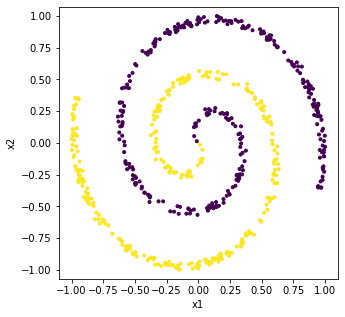

In [9]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

### Epsilon Softmax

In [10]:
xx, yy = xx.to(device), yy.to(device)

In [11]:
class SoftmaxTemp(nn.Module):
    def __init__(self, temp=3.0):
        super().__init__()
        self.temp = temp
        
    def forward(self, x):
        return torch.softmax(x*self.temp, dim=-1)

In [12]:
class ScaleShiftPositive(nn.Module):
    
    def __init__(self, input_dim, scale=1, shift=0):
        super().__init__()
        if scale is False:
            self.scaler = 1
        elif scale is None:
            self.scaler = nn.Parameter(torch.ones(1, input_dim)*0)
        else:
            self.scaler = nn.Parameter(torch.ones(1, input_dim)*np.log(scale))
            
        if shift is False:
            self.shifter = 0
        if shift is None:
            self.shifter = nn.Parameter(torch.ones(1, input_dim)*0)
        else:
            self.shifter =  nn.Parameter(torch.ones(1, input_dim)*shift)
        
    def forward(self, x):
        return x*torch.exp(self.scaler)+self.shifter

In [51]:
class EpsilonSoftmax(nn.Module):
    '''
    Assuming the minimum distance is below epsilon.
    '''
    def __init__(self, epsilon:float=0.1, maxima_above_epsilon:bool=True):
        super().__init__()
        self.epsilon = epsilon
        self.sign = 1
        if not maxima_above_epsilon:
            self.sign = -1
            
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        ## x shape=[batch_size, dimensions]
        bs, _ = x.shape
        return self.softmax(torch.cat([self.sign*x, torch.ones(bs, 1, device=x.device)*self.epsilon], dim=1))#[:, :-1]

In [52]:
x = torch.linspace(0, 1, 10).reshape(1, -1)

In [53]:
EpsilonSoftmax(epsilon=0)(x)

tensor([[0.0545, 0.0609, 0.0681, 0.0761, 0.0850, 0.0950, 0.1062, 0.1187, 0.1326,
         0.1482, 0.0545]])

In [54]:
class Softmax_1(nn.Module):
    '''
    Assuming the minimum distance is below epsilon.
    '''
    def __init__(self):
        super().__init__()
#         self.epsilon = epsilon
#         self.sign = 1
#         if not maxima_above_epsilon:
#             self.sign = -1
            
    def forward(self, x):
        ## x shape=[batch_size, dimensions]
        bs, _ = x.shape
        ex = torch.exp(x)
        sm = ex/(1+ex.sum(dim=1, keepdim=True))
        return sm

In [55]:
Softmax_1()(x)

tensor([[0.0545, 0.0609, 0.0681, 0.0761, 0.0850, 0.0950, 0.1062, 0.1187, 0.1326,
         0.1482]])

## Viz Residual

In [178]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h, temp=10, epsilon=0.1):
        super().__init__()
        self.net = nn.Sequential(
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=temp, shift_init=0.0), ### Shift is learnable, scale is fixed
                            EpsilonSoftmax(epsilon)),
            dtnn.OneActiv(h+1, mode="exp_1.6"), ## Has maximum at 1, max=1
            nn.Linear(h+1, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))


In [179]:
net = ResidualMLP(10).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
# criterion = nn.MSELoss()

_________________________
Epoch: 99, Acc:0.48, Loss:0.7326039671897888
Epoch: 199, Acc:0.58, Loss:0.6857698559761047
Epoch: 299, Acc:0.63, Loss:0.6351271867752075
Epoch: 399, Acc:0.71, Loss:0.584041178226471
Epoch: 499, Acc:0.82, Loss:0.5282477736473083
Epoch: 599, Acc:0.90, Loss:0.4612756371498108
Epoch: 699, Acc:0.91, Loss:0.3912672996520996
Epoch: 799, Acc:0.92, Loss:0.3398587107658386
Epoch: 899, Acc:0.93, Loss:0.29860514402389526
Epoch: 999, Acc:0.93, Loss:0.26561498641967773


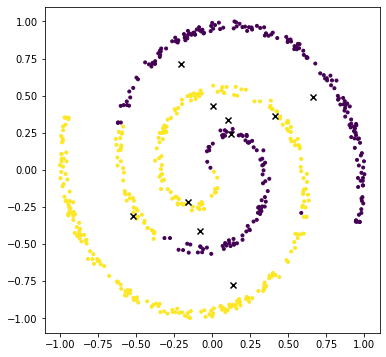

Epoch: 1099, Acc:0.93, Loss:0.23937983810901642
Epoch: 1199, Acc:0.93, Loss:0.21861615777015686
Epoch: 1299, Acc:0.93, Loss:0.20211543142795563
Epoch: 1399, Acc:0.93, Loss:0.18877089023590088
Epoch: 1499, Acc:0.94, Loss:0.17720375955104828
Epoch: 1599, Acc:0.94, Loss:0.16699862480163574
Epoch: 1699, Acc:0.95, Loss:0.1587105542421341
Epoch: 1799, Acc:0.95, Loss:0.15186627209186554
Epoch: 1899, Acc:0.95, Loss:0.14608339965343475
Epoch: 1999, Acc:0.95, Loss:0.1410994529724121


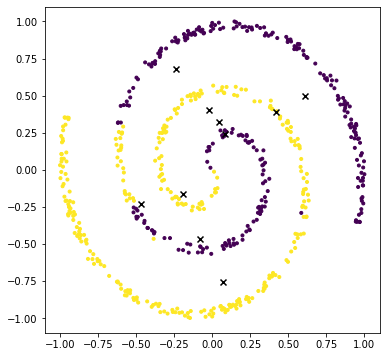

Epoch: 2099, Acc:0.96, Loss:0.13673636317253113
Epoch: 2199, Acc:0.96, Loss:0.13286882638931274
Epoch: 2299, Acc:0.96, Loss:0.12940457463264465
Epoch: 2399, Acc:0.96, Loss:0.1262732595205307
Epoch: 2499, Acc:0.96, Loss:0.1234200969338417
Epoch: 2599, Acc:0.96, Loss:0.12080105394124985
Epoch: 2699, Acc:0.96, Loss:0.11837998777627945
Epoch: 2799, Acc:0.96, Loss:0.11612740159034729
Epoch: 2899, Acc:0.96, Loss:0.11401868611574173
Epoch: 2999, Acc:0.96, Loss:0.11203333735466003


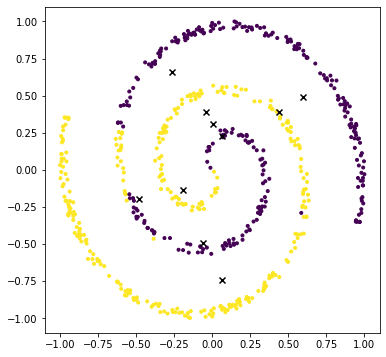

Epoch: 3099, Acc:0.96, Loss:0.11015401780605316
Epoch: 3199, Acc:0.96, Loss:0.1083659902215004
Epoch: 3299, Acc:0.97, Loss:0.1066567674279213
Epoch: 3399, Acc:0.97, Loss:0.10501573234796524
Epoch: 3499, Acc:0.97, Loss:0.1034325510263443
Epoch: 3599, Acc:0.97, Loss:0.10170802474021912
Epoch: 3699, Acc:0.97, Loss:0.10015065968036652
Epoch: 3799, Acc:0.97, Loss:0.09865126013755798
Epoch: 3899, Acc:0.97, Loss:0.09719531983137131
Epoch: 3999, Acc:0.97, Loss:0.09577549248933792


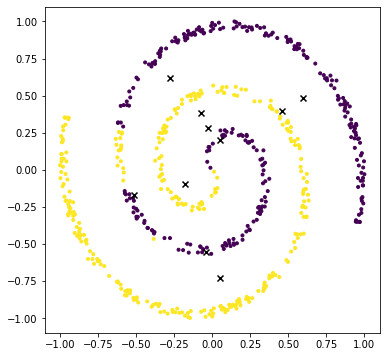

Epoch: 4099, Acc:0.97, Loss:0.09438739717006683
Epoch: 4199, Acc:0.97, Loss:0.09302745014429092
Epoch: 4299, Acc:0.97, Loss:0.09169341623783112
Epoch: 4399, Acc:0.97, Loss:0.09038040041923523
Epoch: 4499, Acc:0.98, Loss:0.08908776938915253
Epoch: 4599, Acc:0.98, Loss:0.08776339143514633
Epoch: 4699, Acc:0.97, Loss:0.08583834767341614
Epoch: 4799, Acc:0.97, Loss:0.08460620045661926
Epoch: 4899, Acc:0.98, Loss:0.08340094238519669
Epoch: 4999, Acc:0.98, Loss:0.08220857381820679


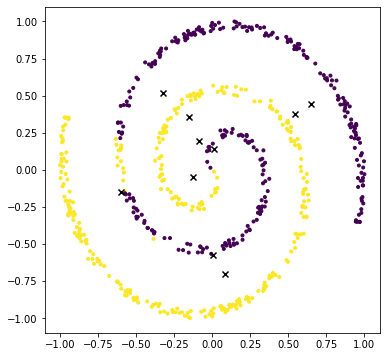

In [180]:
print("_________________________")
for epoch in range(5000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [181]:
xx.device

device(type='cuda', index=0)

In [182]:
net.net[:-1]

Sequential(
  (0): DistanceTransform()
  (1): Sequential(
    (0): ScaleShift()
    (1): EpsilonSoftmax(
      (softmax): Softmax(dim=-1)
    )
  )
  (2): OneActiv()
)

(array([ 29.,  22.,  17.,  25.,  17.,  27.,  27.,  48.,  83., 305.]),
 array([0.40536517, 0.46482864, 0.5242921 , 0.5837556 , 0.6432191 ,
        0.7026826 , 0.76214606, 0.82160956, 0.88107306, 0.9405365 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

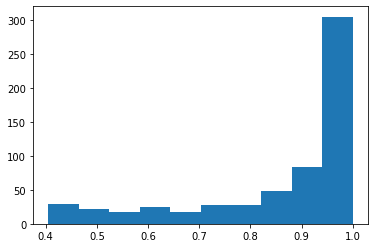

In [183]:
maxvals = net.net[:-1](xx).data.cpu().max(dim=1)[0]
plt.hist(maxvals)

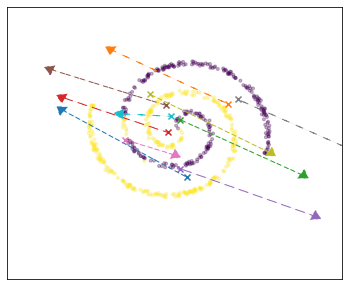

In [184]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = net.net[-1].weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()

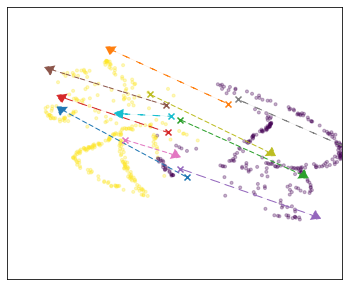

In [185]:
dev = (xx+net.net(xx)*0.5).data.cpu()

ax = plt.figure(figsize=(6,5)).add_subplot()

ax.scatter(dev[:,0], dev[:,1], c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = net.net[-1].weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc='r', ec='r', linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_1.pdf", bbox_inches='tight')
plt.show()

In [186]:
net.net[-1].weight.data.cpu().t() + net.net[-1].bias.data.cpu()

tensor([[-3.0540,  1.9863],
        [-2.8844,  1.6077],
        [ 2.3185, -1.5647],
        [-2.6154,  1.0440],
        [ 2.5921, -1.3400],
        [-2.8353,  1.0697],
        [ 0.7034, -0.3886],
        [ 2.2163, -1.4729],
        [ 2.2765, -1.6597],
        [-1.4071,  0.1107],
        [-0.1551, -0.0323]])

## Debug/Create/Visualize Softmax

In [627]:
# class EpsilonSoftmax(nn.Module):
#     '''
#     Assuming the minimum distance is below epsilon.
#     '''
#     def __init__(self, epsilon:float=0.1, maxima_above_epsilon:bool=True):
#         super().__init__()
#         self.epsilon = epsilon
#         self.sign = 1
#         if not maxima_above_epsilon:
#             self.sign = -1
            
#         self.softmax = nn.Softmax(dim=-1)
        
#     def forward(self, x):
#         ## x shape=[batch_size, dimensions]
#         bs, _ = x.shape
# #         x_s = self.softmax(self.sign*x)
#         x_s = x / x.norm(dim=1, keepdim=True)
#         print(x_s)
#         return self.softmax(torch.cat([x_s, torch.ones(bs, 1, device=x.device)*self.epsilon], dim=1))#[:, :-1]

In [671]:
## This works with DistanceTransformBase
class EpsilonSoftmax(nn.Module):
    def __init__(self, epsilon:float=0.1):
        super().__init__()
        self.epsilon = epsilon
            
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        ## x shape=[batch_size, dimensions]
        bs, _ = x.shape
        return self.softmax(-torch.cat([x, torch.ones(bs, 1, device=x.device)*self.epsilon], dim=1))#[:, :-1]

In [704]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h, temp=10, epsilon=0.1):
        super().__init__()
        self.net = nn.Sequential(
            dtnn.DistanceTransformBase(2, h),
#             dtnn.DistanceTransform(2, h),
            EpsilonSoftmax(epsilon),
            dtnn.OneActiv(h+1, mode="exp_1.6"), ## Has maximum at 1, max=1
            nn.Linear(h+1, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))


In [737]:
net = ResidualMLP(10, temp=1, epsilon=0.2).to(device)

In [738]:
num_points = 400
X1 = np.linspace(-1, 1, num_points)*3
X2 = np.linspace(-1, 1, num_points)*3
X1, X2 = np.meshgrid(X1, X2)

In [739]:
XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)
XX.shape

torch.Size([160000, 2])

In [740]:
# aa = net.net[0](XX[:1, :])
aa = net.net[0](XX)
aa[0]

tensor([4.7663, 3.6859, 4.2162, 4.4795, 4.4185, 4.1029, 4.6258, 4.4768, 4.3692,
        4.1954], device='cuda:0', grad_fn=<SelectBackward>)

In [741]:
net.net[1]

EpsilonSoftmax(
  (softmax): Softmax(dim=-1)
)

In [742]:
probs = net.net[1](aa)
probs.shape

torch.Size([160000, 11])

In [743]:
XX[0]

tensor([-3., -3.], device='cuda:0')

In [744]:
probs[0]

tensor([0.0089, 0.0262, 0.0154, 0.0119, 0.0126, 0.0173, 0.0102, 0.0119, 0.0132,
        0.0158, 0.8565], device='cuda:0', grad_fn=<SelectBackward>)

In [745]:
cls = probs.argmax(dim=-1)
cls

tensor([10, 10, 10,  ..., 10, 10, 10], device='cuda:0')

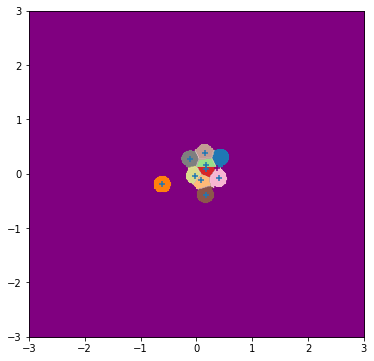

In [746]:
plt.figure(figsize=(6, 6))
cf = plt.contourf(X1, X2, cls.data.cpu().numpy().reshape(X1.shape),
             alpha=1.0, antialiased=True, levels=12, cmap='tab20')

none_idx = torch.nonzero(cls == 10).reshape(-1)
plt.scatter(*XX[none_idx].t().cpu(), marker='+', color="purple")
plt.scatter(*net.net[0].centers.data.cpu().t(), marker='+')

In [616]:
torch.unique(cls.data, return_counts=True)

(tensor([ 9, 10], device='cuda:0'), tensor([  9332, 150668], device='cuda:0'))

In [147]:
XX[torch.nonzero(cls == 10).reshape(-1)].shape

torch.Size([638, 2])

In [154]:
*XX[none_idx].t().cpu()

SyntaxError: can't use starred expression here (<ipython-input-154-fa0486760e2d>, line 1)

In [715]:
net = ResidualMLP(10).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
# criterion = nn.MSELoss()

_________________________
Epoch: 99, Acc:0.69, Loss:0.6385670900344849
Epoch: 199, Acc:0.70, Loss:0.623785674571991
Epoch: 299, Acc:0.71, Loss:0.610235333442688
Epoch: 399, Acc:0.71, Loss:0.5977754592895508
Epoch: 499, Acc:0.71, Loss:0.5867248773574829
Epoch: 599, Acc:0.71, Loss:0.5771504640579224
Epoch: 699, Acc:0.71, Loss:0.5690867304801941
Epoch: 799, Acc:0.70, Loss:0.5622486472129822
Epoch: 899, Acc:0.70, Loss:0.5566027164459229
Epoch: 999, Acc:0.70, Loss:0.5520058274269104


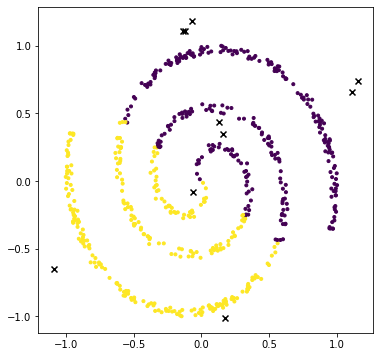

Epoch: 1099, Acc:0.70, Loss:0.5481642484664917
Epoch: 1199, Acc:0.70, Loss:0.5448710322380066
Epoch: 1299, Acc:0.70, Loss:0.5418972969055176
Epoch: 1399, Acc:0.70, Loss:0.5393093824386597
Epoch: 1499, Acc:0.70, Loss:0.5361698269844055
Epoch: 1599, Acc:0.70, Loss:0.5332426428794861
Epoch: 1699, Acc:0.70, Loss:0.5302518606185913
Epoch: 1799, Acc:0.70, Loss:0.5271394848823547
Epoch: 1899, Acc:0.70, Loss:0.5238551497459412
Epoch: 1999, Acc:0.70, Loss:0.5203602313995361


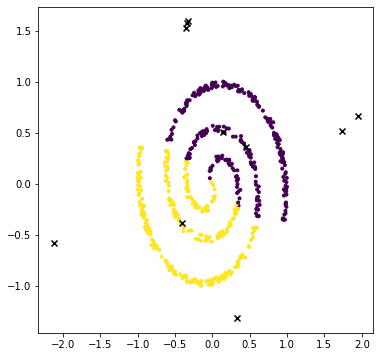

Epoch: 2099, Acc:0.69, Loss:0.5166255831718445
Epoch: 2199, Acc:0.69, Loss:0.5126317739486694
Epoch: 2299, Acc:0.69, Loss:0.5083695650100708
Epoch: 2399, Acc:0.69, Loss:0.5038398504257202
Epoch: 2499, Acc:0.69, Loss:0.49904128909111023
Epoch: 2599, Acc:0.70, Loss:0.49399232864379883
Epoch: 2699, Acc:0.70, Loss:0.4887099862098694
Epoch: 2799, Acc:0.70, Loss:0.4831969439983368
Epoch: 2899, Acc:0.70, Loss:0.47749248147010803
Epoch: 2999, Acc:0.69, Loss:0.4716339111328125


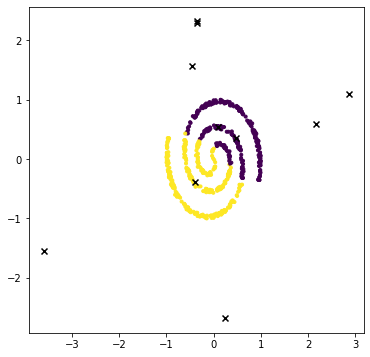

Epoch: 3099, Acc:0.70, Loss:0.4656394422054291
Epoch: 3199, Acc:0.69, Loss:0.4595836102962494
Epoch: 3299, Acc:0.66, Loss:0.45352306962013245
Epoch: 3399, Acc:0.64, Loss:0.4475247859954834
Epoch: 3499, Acc:0.65, Loss:0.4416424036026001
Epoch: 3599, Acc:0.64, Loss:0.43592560291290283
Epoch: 3699, Acc:0.64, Loss:0.4304186999797821
Epoch: 3799, Acc:0.65, Loss:0.42514345049858093


KeyboardInterrupt: 

In [716]:
print("_________________________")
for epoch in range(5000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

## Make it work with un-normalized similarity